In [1]:
# !pip3 install torchtext==0.4

In [2]:
import math
import numpy as np
import pandas as pd
import pdb

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

# from models.LSTM import LSTMClassifier

In [3]:
# model.py

class GANet(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, aux_hidden_size = 100, backbone_hidden_size = 100, tau = 1, biDirectional_aux = False, biDirectional_backbone = False):
        super(GANet, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 6 = (For TREC dataset)
        hidden_sie : Size of the hidden_state of the LSTM   (// Later BiLSTM)
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.aux_hidden_size = aux_hidden_size
        self.backbone_hidden_size = backbone_hidden_size 
        self.mlp_out_size = mlp_out_size
        self.biDirectional_aux = biDirectional_aux
        self.biDirectional_backbone = biDirectional_backbone
        self.tau = tau

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)

        self.auxiliary = AuxiliaryNet(self.batch_size, self.aux_hidden_size, self.embedding_length, self.biDirectional_aux, tau = self.tau)
        self.backbone = BackboneNet(self.batch_size, self.backbone_hidden_size, self.embedding_length, self.biDirectional_backbone)

        if(self.biDirectional_backbone):
            self.mlp = MLP(self.backbone_hidden_size * 2, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size * 2,num_classes)
        else:
            self.mlp = MLP(self.backbone_hidden_size, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size,num_classes)


    def masked_Softmax(self, logits, mask):
        mask_bool = mask>0
        logits[~mask_bool] = float('-inf')
        return torch.softmax(logits, dim=1)

    
    def forward(self,input_sequence, is_train = True):
        input_ = self.word_embeddings(input_sequence)
        g_t, p_t = self.auxiliary(input_, is_train)
        out_lstm = self.backbone(input_)

        if is_train:
            e_t = self.mlp(out_lstm)
#             alpha = torch.softmax(e_t*g_t, dim = 1)
#             pdb.set_trace()
            alpha_numerator = torch.exp(e_t)*g_t
            alpha_denomenator = torch.sum(alpha_numerator, dim=1).repeat(e_t.shape[1],1,1).transpose(0,1)
            alpha = alpha_numerator/alpha_denomenator
        else:
            e_t = self.mlp(out_lstm)               # change if possible!
            alpha = self.masked_Softmax(e_t, g_t)
            
        c_t = torch.bmm(alpha.transpose(1,2), out_lstm)
        logits = self.FF(c_t)
        final_output = torch.softmax(logits, dim = -1)
        # final_output = final_output.max(2)[1]
        final_output = final_output.squeeze(1)

        return final_output, g_t, alpha, p_t

In [4]:
class AuxiliaryNet(torch.nn.Module):
    """
    Arguments
    ---------
    batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
    aux_hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
    embedding_length : Embeddding dimension of GloVe word embeddings
    --------
    """
    def __init__(self, batch_size, auxiliary_hidden_size, embedding_length, biDirectional = False, num_layers = 1, tau=1):
        super(AuxiliaryNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = auxiliary_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional = biDirectional
        self.num_layers = num_layers

        self.aux_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, num_layers = self.num_layers, batch_first = True)   # Dropout  
        if(self.biDirectional):
            self.aux_linear = nn.Linear(self.hidden_size * 2,1)
        else:
            self.aux_linear = nn.Linear(self.hidden_size,1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tau = tau


    def forward(self, input_sequence, is_train = True, batch_size=None):

        # input : Dimensions (batch_size x seq_len x embedding_length)
        out_lstm, (final_hidden_state, final_cell_state) = self.aux_lstm(input_sequence) # ouput dim: (batch_size x seq_len x hidden_size) 
        out_linear = self.aux_linear(out_lstm)                                           # p_t dim: (batch_size x seq_len x 1)
        p_t = self.sigmoid(out_linear)

        if is_train:
            p_t = p_t.repeat(1,1,2)
            p_t[:,:,0] = 1 - p_t[:,:,0] 
            g_hat = F.gumbel_softmax(p_t, self.tau, hard=False)   
#             print("p_t: ", p_t)
            g_t = g_hat[:,:,1]
            g_t = g_t.reshape(g_t.shape[0], g_t.shape[1], 1)
#             print("g_t Gumbel: ", g_t)
        else:
            # size : same as p_t [ batch_size x seq_len x 1]
#             print("Underlying probability distribution: ", p_t)
            m = torch.distributions.bernoulli.Bernoulli(p_t)   
            g_t = m.sample()
            
            # We do not want all the values of g_t for a sample to be 0
            # Make all g_t's 1 when all are zero
            gt_sum = g_t.sum(1)
            x = (gt_sum == 0).nonzero()
            x = x[:,0]
            for i in x:
                g_t[i,:,:] = torch.ones(g_t[i,:,:].shape)
#             print("All zero: ", len(x))
        return g_t, p_t

In [5]:
class BackboneNet(torch.nn.Module):
    """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        backbone_hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
        embedding_length : Embeddding dimension of GloVe word embeddings
        --------
    """
    def __init__(self, batch_size, backbone_hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(BackboneNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = backbone_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional	= biDirectional
        self.num_layers = num_layers

        self.backbone_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.backbone_lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm


In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
        self.relu = nn.ReLU()
        self.ff_2 = nn.Linear(self.output_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
        out_relu = self.relu(out_1)
        out_2 = self.ff_2(out_relu)
        out_sigmoid = self.sigmoid(out_2)

        return out_sigmoid 

In [7]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, optim, train_iter, epoch, batch_size):
    total_epoch_loss = 0
    total_epoch_acc = 0
    # model.cuda()
#     optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction, g_t, alpha, p_t = model(text, is_train = True)
        # print("prediction = ", prediction.shape)
        # print("target = ", target.shape)
        # print("prediction = ", prediction)
        # print("target = ", target)
        
        # Modifies loss function
        loss = loss_fn(prediction, target, g_t)

        # Defualt - Cross entropy loss funtion
#         loss = loss_fn(prediction, target)
        
        # print("loss = ", loss)
        
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 10 == 0:
            # print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
            # break
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_attention =  0
    total_samples = 0 
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction, g_t, alpha, p_t = model(text, is_train = False)
            # Sanity check
            # print("Test Prediction: ", prediction)
            # print("Gate values: ", g_t)

            # For density calculation
            total_attention += torch.sum(g_t)
            # print(total_attention)
            # print(g_t.shape)
            total_samples += g_t.shape[0] * g_t.shape[1]
            
            # Modifies loss function
            loss = loss_fn(prediction, target, g_t)

            # Defualt - Cross entropy loss funtion
#             loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter), total_attention/total_samples 

In [8]:
# data.py
def load_IMDB_data(batch_size= 32, embedding_length = 100):
    # set up fields
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=100)
    # LABEL = data.LabelField()
    LABEL = data.LabelField(dtype=torch.float)

    # make splits for data
    train, test = datasets.IMDB.splits(TEXT, LABEL)
    train, valid = train.split() 
    
    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABEL.build_vocab(train)
    print(LABEL.vocab.__dict__)

    # make iterator for splits
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
      (train, valid, test), batch_size= batch_size, device=0)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

In [9]:
# main.py
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_IMDB_data()

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'pos': 8772, 'neg': 8728}), 'itos': ['pos', 'neg'], 'unk_index': None, 'stoi': defaultdict(None, {'pos': 0, 'neg': 1}), 'vectors': None}


In [10]:
def loss_fn(output, target, g_t, lambda_ = 1e-4):
#     T = g_t.shape[0]*g_t.shape[1]
    T = len(g_t)
    # loss = -nn.LogSoftmax(output[target], dim = 1) + (lambda_ * torch.sum(g_t))/T
    loss = F.cross_entropy(output, target) + (lambda_ * torch.sum(g_t))/T
    return loss

In [11]:
# Over-writing the loss function to simple cross entropy loss
# loss_fn = F.cross_entropy

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 100
num_classes = 2
mlp_out_size = 32
weights = word_embeddings
aux_hidden_size = 100
batch_hidden_size = 100
tau = 1

model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau= tau, biDirectional_aux=False, biDirectional_backbone=False)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [12]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc', 'Val_Density'])

while(True):
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size)
    val_loss, val_acc, val_density = eval_model(model, valid_iter) 
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), "IMDB_LSTM+LSTM_100")
    else:
        num_bad_epochs += 1
#     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%') 
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%, Val Density: {val_density:.4f}')
    print("-------------")
    
    training_stats = training_stats.append(
        pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc, val_density], index=training_stats.columns), 
        ignore_index=True)
#     if num_bad_epochs >= 10:
#         break
        
    epoch += 1
    if epoch == 100:
        break

Epoch: 01
*** Least validation loss
Train Loss: 0.606, Train Acc: 67.53%
Val Loss: 0.589274, Val Acc: 70.44%, Val Density: 0.3734
-------------
Epoch: 02
*** Least validation loss
Train Loss: 0.490, Train Acc: 81.60%
Val Loss: 0.569497, Val Acc: 72.41%, Val Density: 0.2714
-------------


In [13]:
training_stats.to_csv("IMDB_LSTM+LSTM_100.csv")

In [14]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

In [15]:
loaded_model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau= tau, biDirectional_aux=False, biDirectional_backbone=False)
loaded_model.load_state_dict(torch.load('IMDB_LSTM+LSTM_100'))
loaded_model.eval()

GANet(
  (word_embeddings): Embedding(201739, 100)
  (auxiliary): AuxiliaryNet(
    (aux_lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
    (aux_linear): Linear(in_features=200, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (backbone): BackboneNet(
    (backbone_lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=32, bias=True)
    (relu): ReLU()
    (ff_2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (FF): Linear(in_features=200, out_features=2, bias=True)
)

In [16]:
test_loss, test_acc, density = eval_model(loaded_model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}, Density: {density:.4f} ')

Test Loss: 0.581, Test Acc: 71.75, Density: 0.2617 


In [34]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen, volatile=True)

    # print(test_tensor)
    loaded_model.eval()
    prediction, g_t, alpha, p_t = loaded_model(test_tensor, is_train = False)
    print("prediction =", prediction)
#     print("g =", g_t)
    
    for i in range(len(test_sen_list)):
        print(test_sen_list[i], int(g_t[0][i]), float(p_t[0][i][0]), float(alpha[0][i][0]))
    out_class = torch.argmax(prediction)
    return out_class

''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

print('------------')
x = test_sentence(test_sen1)
print(x)
print('------------')
x = test_sentence(test_sen2)
print(x)
print('------------')

------------
['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
prediction = tensor([[1.0000e+00, 5.9342e-10]], grad_fn=<SqueezeBackward1>)
this 0 0.9378951191902161 0.0
is 1 0.9947400689125061 0.04351923242211342
one 1 0.9948108196258545 0.04351923242211342
of 1 0.9973734617233276 0.04351923242211342
the 1 0.9971464276313782 0.04351923242211342
best 1 0.9984948635101318 0.04351923242211342
creation 1 0.9990401864051819 0.04351923242211342
of 1 0.9986294507980347 0.04351923242211342
nolan. 1 0.9942398071289062 0.04351923242211342
i 1 0.9977445602416992 0.04351923242211342
can 1 0.9989503026008606 0.04351923242211342
say, 1 0.9984232187271118 0.04351923242211342
it's 1 0.997162401676178 0.04351923242211342
his 1 0.9973955154418945 0.04351923242211342
magnum 1 0.9982940554618835 0.04351923242211342
opus. 1 0.998584508895874 0.0435

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


In [18]:
training_stats

,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc,Val_Density
0,1,0.606439,67.533135,0.589274,70.438830,tensor(0.3734)
1,2,0.490295,81.604205,0.569497,72.406915,tensor(0.2714)


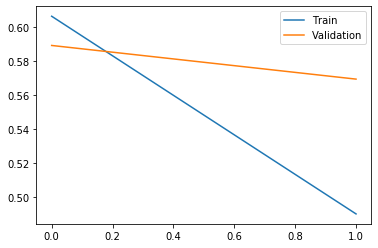

In [19]:
import matplotlib.pyplot as plt
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.legend()
plt.show()

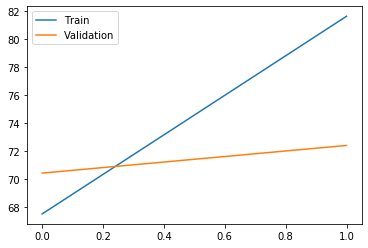

In [20]:
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.legend()
plt.show()

In [21]:
t = torch.rand(2,3,4)
t

tensor([[[0.3196, 0.0464, 0.4322, 0.3626],
         [0.5285, 0.8189, 0.8507, 0.6704],
         [0.4549, 0.1717, 0.9506, 0.4272]],

        [[0.2678, 0.9349, 0.7817, 0.1599],
         [0.5822, 0.6097, 0.1133, 0.1424],
         [0.1226, 0.4948, 0.1211, 0.9528]]])

In [22]:
torch.exp(t)

tensor([[[1.3766, 1.0475, 1.5407, 1.4370],
         [1.6964, 2.2680, 2.3412, 1.9549],
         [1.5760, 1.1874, 2.5873, 1.5330]],

        [[1.3070, 2.5469, 2.1852, 1.1734],
         [1.7900, 1.8398, 1.1199, 1.1530],
         [1.1304, 1.6402, 1.1288, 2.5930]]])

In [23]:
torch.sum(torch.exp(t), dim=1)

tensor([[4.6490, 4.5028, 6.4692, 4.9250],
        [4.2274, 6.0269, 4.4339, 4.9194]])

In [24]:
torch.sum(torch.exp(t), dim=1).repeat(3,1,1).transpose(0,1)

tensor([[[4.6490, 4.5028, 6.4692, 4.9250],
         [4.6490, 4.5028, 6.4692, 4.9250],
         [4.6490, 4.5028, 6.4692, 4.9250]],

        [[4.2274, 6.0269, 4.4339, 4.9194],
         [4.2274, 6.0269, 4.4339, 4.9194],
         [4.2274, 6.0269, 4.4339, 4.9194]]])

In [25]:
torch.exp(t)/torch.sum(torch.exp(t), dim=1).repeat(3,1,1).transpose(0,1)

tensor([[[0.2961, 0.2326, 0.2382, 0.2918],
         [0.3649, 0.5037, 0.3619, 0.3969],
         [0.3390, 0.2637, 0.3999, 0.3113]],

        [[0.3092, 0.4226, 0.4928, 0.2385],
         [0.4234, 0.3053, 0.2526, 0.2344],
         [0.2674, 0.2721, 0.2546, 0.5271]]])

In [26]:
# g_t = torch.tensor([[[1.],
#          [0.],
#          [1.],
#          [0.],
#          [1.],
#          [0.],
#          [1.],
#          [0.],
#          [0.],
#          [0.]],

#         [[0.],
#          [1.],
#          [1.],
#          [1.],
#          [0.],
#          [1.],
#          [1.],
#          [0.],
#          [1.],
#          [1.]],

#         [[0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.]]])

In [27]:
# g_t.shape

In [28]:
# g_t_sum = g_t.sum(1)

In [29]:
# g_t_sum

In [30]:
# x = (g_t_sum == 0).nonzero()

In [31]:
# x = x[:,0]

In [32]:
# x

In [33]:
# for i in x:
#     print("Old g", g_t[i,:,:])
#     new_g = torch.ones(g_t[i,:,:].shape)
#     g_t[i,:,:] = new_g
#     print("New g", g_t[i,:,:])